In [130]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

from eofs.xarray import Eof
from scipy import stats
from scipy.signal import detrend
from sklearn.utils import resample
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

In [2]:
data_path = ('./ERA5_UVTH/')
uwind =[]
for year in range(1973, 2023):
    print(year)
    file_path = os.path.join(data_path,f'{year}_UVTH.nc')
    u = xr.open_dataset(file_path)
    u200=u.sel(level=200)
    uwnd = u200.resample(time='D').mean()
    uwind.append(uwnd)
    
uwind_ds = xr.concat(uwind,dim='time')
uwind_ds['dayofyear'] = uwind_ds['time.dayofyear']
leap_years = (uwind_ds['time.year'] % 4 == 0) & ((uwind_ds['time.year'] % 100 != 0) | (uwind_ds['time.year'] % 400 == 0))
uwind_ds['dayofyear'] = xr.where(leap_years & (uwind_ds['time.month'] > 2),
                                               uwind_ds['dayofyear'] - 1,
                                               uwind_ds['dayofyear'])   

1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [3]:
UVTH_200_Ano = uwind_ds.groupby('dayofyear') - uwind_ds.groupby('dayofyear').mean(dim='time')

In [5]:
Uwind_200_Ano_SS = UVTH_200_Ano.u.sel(latitude=slice(50,20), longitude=slice(40,90))
Uwind_200_Ano_SS = Uwind_200_Ano_SS.drop_vars(['dayofyear'])

In [6]:
Uwind_200_Ano_SS

<xarray.DataArray 'u' (time: 4600, latitude: 31, longitude: 51)>
array([[[ -6.911176  ,  -6.0470347 ,  -5.317192  , ..., -12.407714  ,
         -11.998837  , -10.999029  ],
        [ -5.190723  ,  -4.333314  ,  -3.679492  , ..., -12.125617  ,
         -11.7694025 , -11.013352  ],
        [ -2.9490614 ,  -2.2196236 ,  -1.7177715 , ..., -12.267016  ,
         -11.485214  , -10.746289  ],
        ...,
        [ -1.6156006 ,  -2.0105553 ,  -2.4959526 , ...,  10.240231  ,
           9.6441    ,   9.566357  ],
        [ -1.9591751 ,  -2.2416763 ,  -2.8099442 , ...,   9.299046  ,
           8.813906  ,   8.595354  ],
        [ -1.9065361 ,  -1.9769726 ,  -2.3234177 , ...,   8.059408  ,
           7.8349304 ,   7.8727036 ]],

       [[-12.874897  , -11.660709  , -10.510466  , ..., -19.022009  ,
         -18.387428  , -17.71681   ],
        [-11.91711   , -10.880487  ,  -9.366042  , ..., -18.478119  ,
         -17.355556  , -16.44363   ],
        [-10.345707  ,  -8.610296  ,  -7.429158  , ..., -17.503052  ,
         -16.13329   , -15.0023    ],
...
        [ -9.678609  ,  -9.582308  ,  -9.211216  , ...,  -6.852281  ,
          -6.6498337 ,  -4.287388  ],
        [ -9.095737  ,  -9.33171   ,  -9.441982  , ...,  -6.451356  ,
          -7.3406625 ,  -6.005744  ],
        [ -9.06875   ,  -9.138859  ,  -9.648611  , ...,  -7.459734  ,
          -8.212775  ,  -8.529774  ]],

       [[  7.555432  ,   7.4321213 ,   7.4119625 , ...,   3.6668453 ,
           4.9469337 ,   5.886265  ],
        [  6.4514756 ,   6.535883  ,   6.4677835 , ...,   0.11795998,
           0.92928314,   2.0751305 ],
        [  5.622054  ,   5.588306  ,   4.8971014 , ...,  -2.2475662 ,
          -2.3572197 ,  -0.6946335 ],
        ...,
        [ -8.906042  ,  -9.070263  ,  -9.694224  , ...,  -6.0922165 ,
          -6.477003  ,  -6.592868  ],
        [ -7.3015194 ,  -7.6633496 ,  -8.043169  , ...,  -6.652625  ,
          -6.207236  ,  -6.565983  ],
        [ -5.471878  ,  -5.848963  ,  -5.9922323 , ...,  -5.6409683 ,
          -5.5885296 ,  -5.698304  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 40.0 41.0 42.0 43.0 ... 87.0 88.0 89.0 90.0
  * latitude   (latitude) float32 50.0 49.0 48.0 47.0 ... 23.0 22.0 21.0 20.0
    level      (time) int32 200 200 200 200 200 200 ... 200 200 200 200 200 200
  * time       (time) datetime64[ns] 1973-03-01 1973-03-02 ... 2022-05-31

In [8]:

data1 = xr.Dataset({"u": (('time','lat','lon'), Uwind_200_Ano_SS.values)},
                           coords={'time':Uwind_200_Ano_SS.time.values,'lat': Uwind_200_Ano_SS.latitude.values, 'lon': Uwind_200_Ano_SS.longitude.values})

coslat = np.cos(np.deg2rad(data1.u.lat.values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(data1['u'],weights=wgts)

eofs = solver.eofs(neofs=3)
pcs = solver.pcs(npcs=3, pcscaling=1)
eofs=eofs*-1
pcs=pcs*-1

var_frac = solver.varianceFraction(neigs=3)*100

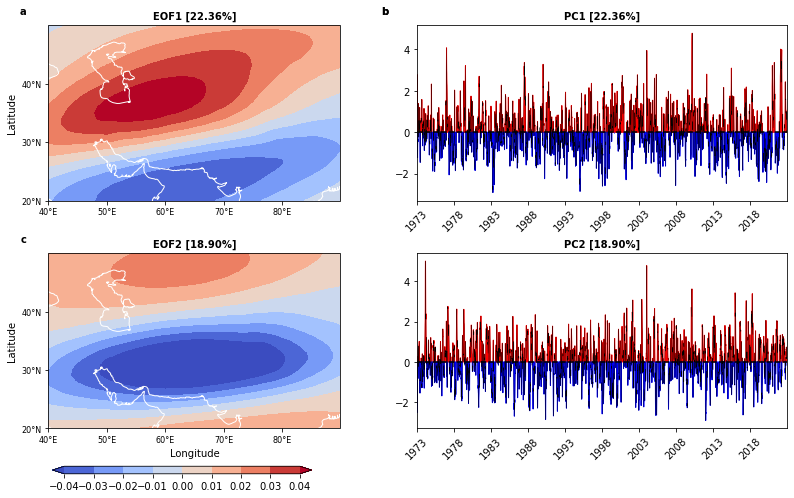

In [25]:
fig = plt.figure(figsize=(12,7))

clev=np.arange(-0.04,0.041,0.01)
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), fig=fig, projection=ccrs.PlateCarree())

cf_plot = ax1.contourf(eofs.lon, eofs.lat, eofs.sel(mode=0),clev,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

ax1.add_feature(cfeature.COASTLINE, edgecolor='white')

ax1.set_xticks(np.arange(40,90,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(20,50,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax1.tick_params(axis='both', which='major', labelsize=8)

#ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
vf = var_frac.sel(mode=0).values
ax1.set_title(f'EOF1 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), fig=fig, projection=ccrs.PlateCarree())

cf_plot = ax2.contourf(eofs.lon, eofs.lat, eofs.sel(mode=1),clev,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

ax2.add_feature(cfeature.COASTLINE, edgecolor='white')

ax2.set_xticks(np.arange(40,90,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)

ax2.set_yticks(np.arange(20,50,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax2.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
 
vf = var_frac.sel(mode=1).values
ax2.set_title(f'EOF2 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

###

ax3 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), fig=fig)

year_ticks = range(1, 4601, 92*5)  
year_labels = range(1973, 2023, 5)  
pc1 = pcs.sel(mode=0)
ax3.plot(range(1, 4601), pc1.values, linewidth=0.3, color='black')  
ax3.fill_between(range(1, 4601), pc1.values, color='red', where=(pc1 >= 0)) 
ax3.fill_between(range(1, 4601), pc1.values, color='blue', where=(pc1 < 0))  
ax3.set_xticks(year_ticks)
ax3.set_xticklabels(year_labels, rotation=45) 
ax3.set_xlim(1, 4600)  # Changed to set_xlim
ax3.axhline(0, color='k', linestyle='--')
vf = var_frac.sel(mode=0).values
ax3.set_title(f'PC1 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax3.text(-0.075, 1.05, 'b', verticalalignment='bottom', horizontalalignment='right', transform=ax3.transAxes, color='k', weight='bold')

###
ax4 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), fig=fig)

year_ticks = range(1, 4601, 92*5)  
year_labels = range(1973, 2023, 5)  
pc1 = pcs.sel(mode=1)
ax4.plot(range(1, 4601), pc1.values, linewidth=0.3, color='black')  
ax4.fill_between(range(1, 4601), pc1.values, color='red', where=(pc1 >= 0)) 
ax4.fill_between(range(1, 4601), pc1.values, color='blue', where=(pc1 < 0))  
ax4.set_xticks(year_ticks)
ax4.set_xticklabels(year_labels, rotation=45) 
ax4.set_xlim(1, 4600)  # Changed to set_xlim
ax4.axhline(0, color='k', linestyle='--')
vf = var_frac.sel(mode=1).values
ax4.set_title(f'PC2 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax4.text(-0.075, 1.05, 'b', verticalalignment='bottom', horizontalalignment='right', transform=ax3.transAxes, color='k', weight='bold')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.3)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.1, 0.01, 0.3, 0.015])

# Draw the colorbar
cbar=fig.colorbar(cf_plot, cax=cbar_ax,orientation='horizontal')

plt.savefig('EOF_Daily.jpg', dpi=600,bbox_inches='tight')

In [33]:
pc1 = pcs.sel(mode=0)

In [185]:
PC1_South = pc1.where(pc1 < 0.5, drop=True)
PC1_North = pc1.where(pc1 > 0.5, drop=True)

In [186]:
R1_hot_days = PC1_North.sel(time=slice('1973','1997'))
R2_hot_days = PC1_North.sel(time=slice('1998','2022'))

In [187]:
R2_hot_days

<xarray.DataArray 'pcs' (time: 748)>
array([1.68068   , 1.281944  , 1.1142466 , 1.1956145 , 1.2605921 ,
       0.96510524, 1.0415697 , 0.6476838 , 0.72990334, 0.9976325 ,
       1.3701644 , 1.9568937 , 1.8205878 , 1.8086458 , 1.9659569 ,
       1.0300463 , 0.95313317, 1.2402556 , 1.1623765 , 1.3302453 ,
       1.2075038 , 1.1422762 , 0.75656676, 0.642306  , 0.66839087,
       1.1514357 , 1.2233471 , 1.1137556 , 0.8600576 , 0.8761462 ,
       0.50993943, 0.5315428 , 1.2076671 , 1.5734873 , 1.402761  ,
       0.9271843 , 0.74004954, 0.73066074, 0.73346215, 0.8262553 ,
       0.860879  , 0.58025795, 1.7969356 , 2.2878706 , 2.3246496 ,
       2.2859008 , 2.3598826 , 1.972856  , 1.2113942 , 0.5871217 ,
       0.5739998 , 0.6864364 , 0.9615828 , 1.2595826 , 1.0540439 ,
       0.81465554, 0.98037565, 0.8412524 , 0.717248  , 0.64932024,
       0.73608446, 0.8968351 , 1.1318918 , 1.5953039 , 1.8299508 ,
       1.9013538 , 1.7956985 , 1.7695063 , 1.4661897 , 0.93954223,
       0.69766474, 0.77156126, 0.75400335, 0.8941186 , 1.1892631 ,
       1.3723636 , 1.2044003 , 0.98466635, 1.0577127 , 0.93563217,
       1.1253953 , 1.3190827 , 0.6650572 , 0.5479233 , 1.3620414 ,
       1.9815322 , 1.7475374 , 1.4735334 , 1.0931578 , 0.80224836,
       0.71291935, 0.6875567 , 0.5857733 , 0.64120185, 0.93042475,
       1.2968793 , 1.0162518 , 0.9265481 , 0.8206814 , 0.55051184,
...
       0.8523717 , 0.91602063, 0.9733656 , 1.0334415 , 1.000738  ,
       0.5638893 , 0.5926899 , 0.946984  , 1.2324533 , 1.1052347 ,
       0.9243117 , 0.8296779 , 2.2105896 , 2.4154136 , 2.6799417 ,
       3.2208605 , 2.845655  , 2.4525747 , 1.8445079 , 1.5395808 ,
       1.3136922 , 1.0858889 , 1.496274  , 1.5064116 , 0.74113095,
       0.7417363 , 0.6514644 , 0.6815598 , 0.6312848 , 0.5840168 ,
       0.7515508 , 0.86623144, 1.2356969 , 1.834503  , 2.4554188 ,
       3.032117  , 3.3670666 , 3.3436618 , 2.767063  , 2.43791   ,
       1.729565  , 1.5952821 , 1.8487335 , 1.3292112 , 0.51918286,
       0.52958065, 0.5405596 , 0.546     , 1.1073414 , 1.529853  ,
       2.236214  , 2.702481  , 2.821966  , 2.981059  , 3.5826883 ,
       3.7626579 , 4.016376  , 3.5378163 , 2.9355547 , 2.613009  ,
       2.4224663 , 2.6102002 , 3.1706655 , 3.42589   , 3.1755517 ,
       3.0571098 , 3.6244242 , 3.7934813 , 3.9850667 , 3.0989802 ,
       2.0562534 , 1.4805433 , 0.7885163 , 0.6769553 , 0.8191714 ,
       0.87535363, 0.7119094 , 0.5573914 , 0.89642906, 1.6192068 ,
       2.2104318 , 2.4350817 , 1.9717077 , 1.5719032 , 1.6112459 ,
       1.4352059 , 1.1148493 , 1.0800464 , 1.0467867 , 0.9214886 ,
       1.0265344 , 0.74910635, 0.60867137, 0.62442136, 0.7578779 ,
       0.9592864 , 0.9485742 , 0.60177207], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1998-03-18 1998-03-19 ... 2022-05-28
    mode     int64 0

In [188]:
years = np.arange(1973, 2023)

freq = np.zeros([np.size(years)]) 
persis = np.zeros([np.size(years)])

for yr, year in enumerate(range(1973, 2023)):
    PC1_year = PC1_North.sel(time=f'{year}')
    if PC1_year.size == 0:
        freq[yr] = 0
        persis[yr] = 0
    else:
        df_hd = PC1_year.to_dataframe()
        df_hd['group'] = (df_hd.index.to_series().diff() != pd.Timedelta(days=1)).cumsum()
        grouped = df_hd.groupby('group')
        dataframes_list = [group.drop(columns='group') for _, group in grouped]
        freq[yr]= sum(len(df) for df in dataframes_list)
        persis[yr] = max(len(df) for df in dataframes_list)  # HWD: Length of the dataframe with maximum values
        
PC1_Aspect = xr.Dataset({"Freq": (('year'), freq),
                           "Persist": (('year'), persis)},
                           coords={'year':years})    

In [168]:
from pyhomogeneity import pettitt_test
cp_test_res = pettitt_test(freq)

In [169]:
cp_test_res

Pettitt_Test(h=False, cp=25, p=0.2613, U=192.0, avg=mean(mu1=22.68, mu2=29.92))

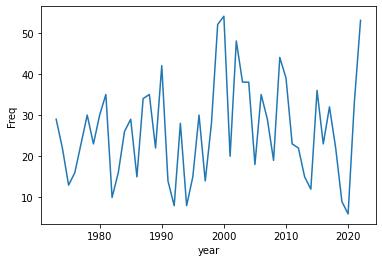

In [172]:
PC1_Aspect.Freq.plot()

In [58]:
data_path = ('../ERA5_T2/')
t2m_max =[]
for year in range(1973, 2023):
    print(year)
    file_path = os.path.join(data_path,f'T2_hourly-{year}-1deg.nc')
    t2m = xr.open_dataset(file_path)    
    temp_max = t2m.resample(time='D').max()
    t2m_max.append(temp_max)

1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [59]:
ds = xr.concat(t2m_max,dim='time')
lsm= xr.open_dataset('land_sea_mask.nc')
mask = lsm.lsm.values
ds = ds.where(mask != 0, float('nan'))
Tmax = ds - 273.15
Tmax = Tmax.where(~((Tmax['time.month'] == 2) & (Tmax['time.day'] == 29)), drop=True)
Tmax_MAM = Tmax.sel(time=Tmax['time.season'] == 'MAM')

In [61]:
Tmax_MAM['dayofyear'] = Tmax_MAM['time.dayofyear']
leap_years = (Tmax_MAM['time.year'] % 4 == 0) & ((Tmax_MAM['time.year'] % 100 != 0) | (Tmax_MAM['time.year'] % 400 == 0))
Tmax_MAM['dayofyear'] = xr.where(leap_years & (Tmax_MAM['time.month'] > 2),
                                               Tmax_MAM['dayofyear'] - 1,
                                               Tmax_MAM['dayofyear'])
Tmax_MAM_Ano = Tmax_MAM.groupby('dayofyear') - Tmax_MAM.groupby('dayofyear').mean(dim='time')

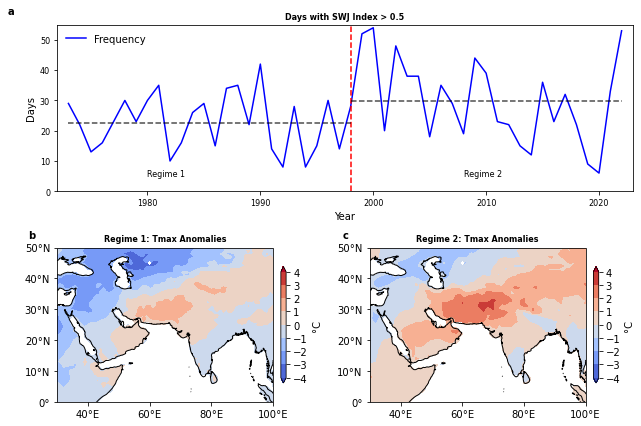

In [197]:
pc1_mu1 = PC1_Aspect.Freq.sel(year=slice('1973','1997')).mean(dim='year')
pc1_mu2 = PC1_Aspect.Freq.sel(year=slice('1998','2022')).mean(dim='year')
R1_Tmax_Ano = Tmax_MAM_Ano.t2m.sel(time=R1_hot_days.time.values).mean(dim='time')
R2_Tmax_Ano = Tmax_MAM_Ano.t2m.sel(time=R2_hot_days.time.values).mean(dim='time')

fig = plt.figure(figsize=(9,6))
ax2= plt.subplot2grid(shape=(2,2), loc=(0, 0), colspan=2, fig=fig)
ax2.plot(PC1_Aspect.year, PC1_Aspect.Freq,label="Frequency",color='blue')
ax2.axvline(x=years[25], color='r', linestyle='--')

ax2.plot([1973, years[25]], [pc1_mu1, pc1_mu1], color='k', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_imd}')
ax2.plot([years[25],2022], [pc1_mu2, pc1_mu2], color='k', linestyle='--',alpha=0.7) #, label=f'Regime 2 Mean: {mu2_imd}')
ax2.set_xlim(1972,2023)
ax2.set_ylim(0,55)

ax2.text(1980, 5, "Regime 1", fontsize=8)
ax2.text(2008, 5, "Regime 2", fontsize=8)
ax2.legend(loc='upper left',frameon=False, ncol=1)
ax2.set_ylabel('Days', fontsize=10)
ax2.set_xlabel('Year', fontsize=10)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_title('Days with SWJ Index > 0.5',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

###

ax1 = plt.subplot2grid(shape=(2,2), loc=(1, 0), colspan=1, fig=fig, projection=ccrs.PlateCarree())
clevs=np.arange(-4,5,1)
cf_plot = ax1.contourf(R1_Tmax_Ano.longitude, R1_Tmax_Ano.latitude, R1_Tmax_Ano,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('°C')
ax1.coastlines()
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_extent([30, 100, 0, 50],crs=ccrs.PlateCarree())
ax1.set_title('Regime 1: Tmax Anomalies',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax1.text(-0.1, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax3 = plt.subplot2grid(shape=(2,2), loc=(1, 1), colspan=1, fig=fig, projection=ccrs.PlateCarree())
cf_plot = ax3.contourf(R2_Tmax_Ano.longitude, R2_Tmax_Ano.latitude, R2_Tmax_Ano,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('°C')
ax3.coastlines()
ax3.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_extent([30, 100, 0, 50],crs=ccrs.PlateCarree())
ax3.set_title('Regime 2: Tmax Anomalies',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax3.text(-0.1, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

######
plt.tight_layout()

plt.savefig('Figure_5_1_NM.jpg', dpi=600,bbox_inches='tight')

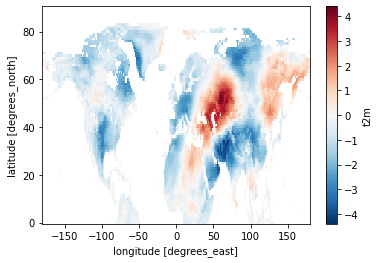

In [83]:
Tmax_MAM_Ano.t2m.sel(time=R1_cold_days.time.values).mean(dim='time').plot()

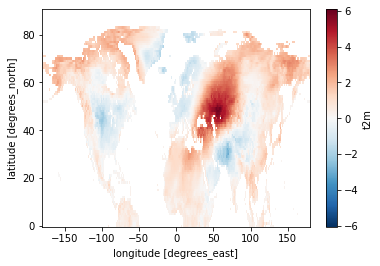

In [84]:
Tmax_MAM_Ano.t2m.sel(time=R2_cold_days.time.values).mean(dim='time').plot()

In [38]:
uvth = xr.open_dataset('UVTH_Daily.nc')
wv = xr.open_dataset('WV_Daily.nc')

In [39]:
uwind = uvth.u
vwind = uvth.v
gph = uvth.z
vort = wv.vo

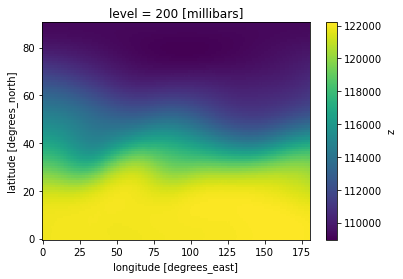

In [87]:
gph.sel(time=R1_hot_days.time.values,level=200).mean(dim='time').plot()

In [88]:
uwind_R1 = uwind.sel(level=[200,500],time=R1_hot_days.time.values)
uwind_R2 = uwind.sel(level=[200,500],time=R2_hot_days.time.values)

lats = uwind_R1.latitude.values
lons = uwind_R1.longitude.values
levs = uwind_R1.level.values

diff_R2_R1 = uwind_R2.mean(dim=['time']) - uwind_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(uwind_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(uwind_R1[:,k,i,j], uwind_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


uwind_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), uwind_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), uwind_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

############
vwind_R1 = vwind.sel(level=[200,500],time=R1_hot_days.time.values)
vwind_R2 = vwind.sel(level=[200,500],time=R2_hot_days.time.values)

lats = vwind_R1.latitude.values
lons = vwind_R1.longitude.values
levs = vwind_R1.level.values

diff_R2_R1 = vwind_R2.mean(dim=['time']) - vwind_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(vwind_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(vwind_R1[:,k,i,j], vwind_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


vwind_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), vwind_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), vwind_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

############
                            
gph_R1 = gph.sel(level=[200,500],time=R1_hot_days.time.values)/9.80665
gph_R2 = gph.sel(level=[200,500],time=R2_hot_days.time.values)/9.80665

lats = gph_R1.latitude.values
lons = gph_R1.longitude.values
levs = gph_R1.level.values

diff_R2_R1 = gph_R2.mean(dim=['time']) - gph_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(gph_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(gph_R1[:,k,i,j], gph_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


gph_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), gph_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), gph_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

######
                        

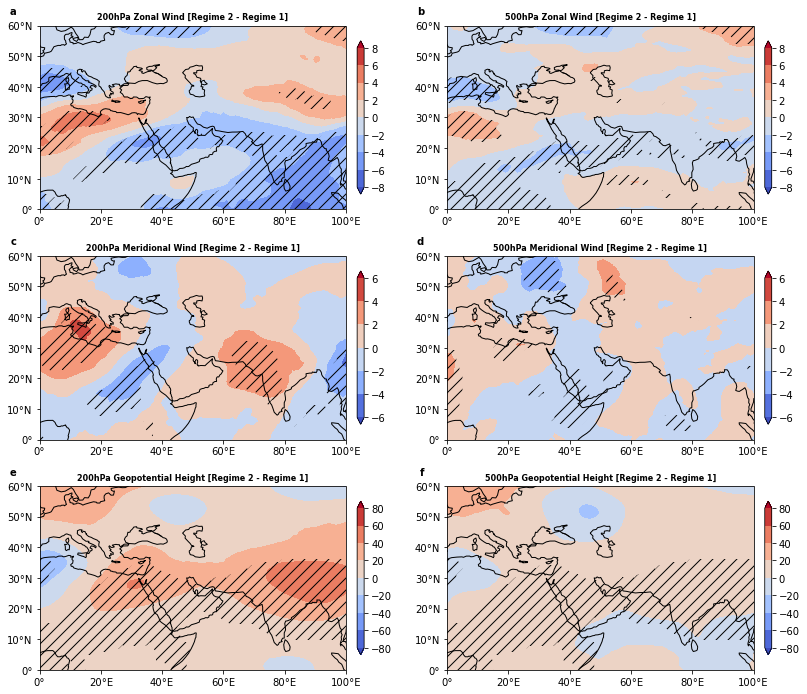

In [89]:

fig = plt.figure(figsize=(14,12))
plev=200

ax1 = plt.subplot2grid(shape=(3,4), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = uwind_Regime.dif.sel(level=plev)
clevs=np.arange(-8,9,2)
cf_plot = ax1.contourf(uwind_Regime.lon, uwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(uwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax1.contourf(uwind_Regime.lon, uwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax1.set_title(f'{plev}hPa Zonal Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax2 = plt.subplot2grid(shape=(3,4), loc=(1, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vwind_Regime.dif.sel(level=plev)
clevs=np.arange(-6,7,2)
cf_plot = ax2.contourf(vwind_Regime.lon, vwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(vwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax2.contourf(vwind_Regime.lon, vwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax2.set_title(f'{plev}hPa Meridional Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

######

ax3 = plt.subplot2grid(shape=(3,4), loc=(2, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = gph_Regime.dif.sel(level=200)
clevs=np.arange(-80,90,20)
cf_plot = ax3.contourf(gph_Regime.lon, gph_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(gph_Regime.sig.sel(level=200) == 1, 1, np.nan)
hatch_plot = ax3.contourf(gph_Regime.lon, gph_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax3.set_title(f'{plev}hPa Geopotential Height [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax3.text(-0.075, 1.05, 'e',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

###########################################################
plev=500

ax4 = plt.subplot2grid(shape=(3,4), loc=(0, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = uwind_Regime.dif.sel(level=plev)
clevs=np.arange(-8,9,2)
cf_plot = ax4.contourf(uwind_Regime.lon, uwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(uwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax4.contourf(uwind_Regime.lon, uwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax4.set_title(f'{plev}hPa Zonal Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax4.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')

####

ax5 = plt.subplot2grid(shape=(3,4), loc=(1, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vwind_Regime.dif.sel(level=plev)
clevs=np.arange(-6,7,2)
cf_plot = ax5.contourf(vwind_Regime.lon, vwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(vwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax5.contourf(vwind_Regime.lon, vwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax5.yaxis.set_major_formatter(lat_formatter)
ax5.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax5.set_title(f'{plev}hPa Meridional Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax5.text(-0.075, 1.05, 'd',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')

######

ax6 = plt.subplot2grid(shape=(3,4), loc=(2, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = gph_Regime.dif.sel(level=plev)
clevs=np.arange(-80,90,20)
cf_plot = ax6.contourf(gph_Regime.lon, gph_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(gph_Regime.sig.sel(level=200) == 1, 1, np.nan)
hatch_plot = ax6.contourf(gph_Regime.lon, gph_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax6.yaxis.set_major_formatter(lat_formatter)
ax6.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax6.set_title(f'{plev}hPa Geopotential Height [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax6.text(-0.075, 1.05, 'f',verticalalignment='bottom', horizontalalignment='right',transform=ax6.transAxes,color='k', weight='bold')

plt.show()
#plt.savefig('Figure_5_1_NM.jpg', dpi=600,bbox_inches='tight')

In [51]:
vort_R1 = vort.sel(time=R1_hot_days.time.values)
vort_R2 = vort.sel(time=R2_hot_days.time.values)

lats = vort_R1.latitude.values
lons = vort_R1.longitude.values
levs = vort_R1.level.values

diff_R2_R1 = vort_R2.mean(dim=['time']) - vort_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(vort_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(vort_R1[:,k,i,j], vort_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


vort_Regime = xr.Dataset({"Regime1": (('level','lat','lon'), vort_R1.mean(dim=['time']).values),
                           "Regime2": (('level','lat','lon'), vort_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})                         

Text(-0.075, 1.05, 'b')

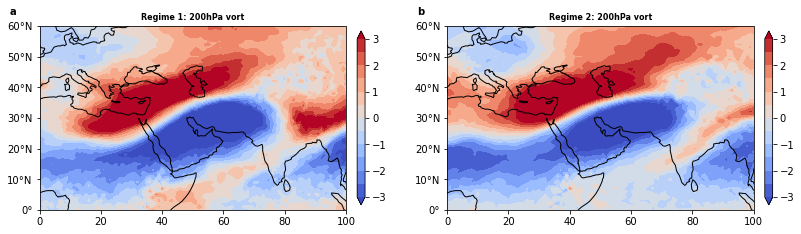

In [52]:
fig = plt.figure(figsize=(14,4))

plev=200
ax4 = plt.subplot2grid(shape=(1,4), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
clevs=np.arange(-3,3.5,0.5)
data = vort_Regime.Regime1.sel(level=plev)*10**5

# Plot the trend data using contourf
cf_plot = ax4.contourf(vort_Regime.lon, vort_Regime.lat, data,clevs,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
# Add hatching to the sections where p-value is 1
#pvalue_mask = np.where(vort_Regime.sig.sel(level=plev) == 1, 1, np.nan)
#hatch_plot = ax4.contourf(vort_Regime.lon, vort_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax4.coastlines()

# Longitude labels
ax4.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
#ax4.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax4.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax4.yaxis.set_major_formatter(lat_formatter)

# Crop the plot
ax4.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())

# Title
ax4.set_title(f'Regime 1: {plev}hPa vort',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax4.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')
####

ax5 = plt.subplot2grid(shape=(1,4), loc=(0, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vort_Regime.Regime2.sel(level=plev)*10**5

# Plot the trend data using contourf
cf_plot = ax5.contourf(vort_Regime.lon, vort_Regime.lat, data,clevs,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
# Add hatching to the sections where p-value is 1
#pvalue_mask = np.where(vort_Regime.sig.sel(level=plev) == 1, 1, np.nan)
#hatch_plot = ax5.contourf(vort_Regime.lon, vort_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax5.coastlines()

# Longitude labels
ax5.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
#ax4.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax5.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax5.yaxis.set_major_formatter(lat_formatter)

# Crop the plot
ax5.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())

# Title
ax5.set_title(f'Regime 2: {plev}hPa vort',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax5.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')

#plt.savefig('Figure_SX_NM.jpg', dpi=600,bbox_inches='tight')

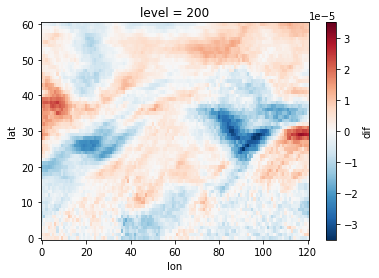

In [56]:
vort_Regime.dif.sel(level=200).plot()